# Synthetic Data

Not focused on Generative Adversarial Networks (although that's possible)

Focused on Database, ETL, and data analytics

Steven Lott

## About Me

I hold a patent in some synthetic data processing.

Not for generative machine learning models. (I need to say that early and often.)

# Agenda

1. What do you mean "Synthetic Data"?  

    Isn't "synthetic" a silly distinction?

2. Why bother?

3. Some tooling for creating useful synthetic data

4. The Cool Stuff

# Part 1. What do you mean Synthetic?

- Created.

- Not collected.

- Free from difficult-to-explain features.

- Not necessarily useful for Generative AI Models

## Test Cases

Test cases use made-up (synthetic) data.

In [1]:
from string import punctuation, whitespace

def some_func(x):
    """
    >>> some_func("hello world") = {'d', 'e', 'h', 'l', 'o', 'r', 'w'}
    """
    return set(x) - (set(punctuation) | set(whitespace))

We can test by monkeypatching the `set()`, replacing it with a `MagicMock`.

And assure that some `sentinel` objects were operated on.

Check the call history to look for `__sub__()` and `__or__()` operations.

## But... 

Using `Sentinel` and `Mock` isn't very compelling.

It tells us the implementation does some specific steps.

But does it tell us the implementation will get the right answer?

(Hint: Not really.)

# Part 2. Why Bother?

Or

How is this even a thing?

## Question of Scale

- A single example is "artisinal data"

- A bunch of examples is "data"

How big a "bunch" do we need?

## Boundary Value Analysis

6 common cases:

Min - 1, Min, Min + 1, "Nominal Value", Max - 1, Max, Max + 1

Is that enough? One value in range?

In [2]:
from math import gamma

def factorial(n):
    return gamma(n + 1)

In [3]:
factorial(5)

120.0

In [4]:
factorial(4.5)

52.34277778455352

In [5]:
factorial(-0.5)**2

3.1415926535897927

## Unfair!

Boundary analysis was clear: -0.5 was out-of-bounds.

Testing float values for what appears to be an int function isn't right.

- Like lifting your lawn mower to trim your hedge.

- Not the point of synthetic data.

## Better Examples

Database design.

- Does the SQL perform?

- Or is a different non-relational model better?

Algorithm design.

Network design.

**Does it scale?**

## Consider
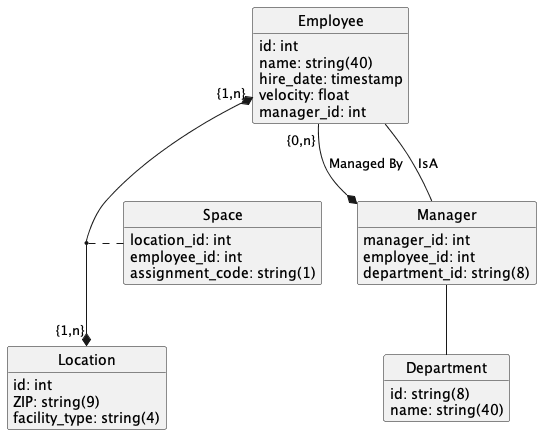

What locations does a department use?

When there are 40,000 employees? 5,000 managers?

## Common Approach

- Mock up a few Departments with a few Locations.

- Use **Boundary Value Analysis** to handle optional, missing, and special-case relationsips.

- One -- maybe two -- of each.

- Lovingly hand-craft the `INSERT` statements.

## Better Approach

1. Define the schema in considerable, realistic detail.

2. Build representative data in representative volumes.

3. Load a database. Populate optimizer statistics.

4. Run the queries.

5. Refine the schema when it performs poorly.

6. Define transactions and updates to examine statistics processing.

## Impediments

- SQL Schema is a flaming dumpster fire.

- Even JSON schema lacks details.

- Distributions and Histograms are **required**.

    - For new development, guess wisely.
    - You'll guess wrong: plan for change.

# Part 3. Some tooling for creating useful synthetic data

- Schema Definition

- Data Generation

See https://github.com/slott56/DataSynthTool

## Schema Definition

- Define schema with JSONSchema + Extensions.

- Use JSONSchema to synthesize data.

- If you're using a SQL database, map JSONSchema to SQL.

It's fun to use **Pydantic** to generate JSONSchema.

### Starting Point -- Design

Use PlantUML to sketch the data model.

It draws diagrams.

```plantuml
@startuml
class Employee {
    id: int
    {field} name: string(40)
    hire_date: timestamp
    velocity: float
    manager_id: int
}
@enduml
```

### Refine to Pydantic Model

In [6]:
import datetime
from typing import Annotated
from pydantic import BaseModel, Field

class Employee(BaseModel):
    id: int
    name: Annotated[
        str, Field(max_length=40)]
    hire_date: Annotated[
        datetime.datetime, Field(ge=datetime.datetime(2021, 1, 18))]
    velocity: Annotated[
        float, Field(ge=2, le=21, 
                     json_schema_extra={"distribution": "Normal"})]
    manager: Annotated[
        int, Field(json_schema_extra={"sql": {'foreignKey': 'Manager.id'}})]

### Create JSONSchema from class definition

In [7]:
from pprint import pprint
pprint(Employee.model_json_schema())

{'properties': {'hire_date': {'format': 'date-time',
                              'title': 'Hire Date',
                              'type': 'string'},
                'id': {'title': 'Id', 'type': 'integer'},
                'manager': {'sql': {'foreignKey': 'Manager.id'},
                            'title': 'Manager',
                            'type': 'integer'},
                'name': {'maxLength': 40, 'title': 'Name', 'type': 'string'},
                'velocity': {'distribution': 'Normal',
                             'maximum': 21.0,
                             'minimum': 2.0,
                             'title': 'Velocity',
                             'type': 'number'}},
 'required': ['id', 'name', 'hire_date', 'velocity', 'manager'],
 'title': 'Employee',
 'type': 'object'}


## Data Generation

An initial proof-of-concept design that works.

But has limitations.

In [8]:
def get_meta(cls_, getter, field):
    matches = [m for m in field.metadata if isinstance(m, cls_)]
    if len(matches) == 0:
        return None
    elif len(matches) != 1:
        raise ValueError(f"{matches}")
    else:
        return getter(matches[0])

### Build Field Values

In [9]:
from typing import Any
from pydantic.fields import FieldInfo
from annotated_types import MaxLen, Ge, Le
from operator import attrgetter

def field_generate(field: FieldInfo) -> Any:
    if issubclass(field.annotation, str):
        size = get_meta(MaxLen, attrgetter("max_length"), field)
        print("String", size, field.metadata, field.json_schema_extra)
        return "String"
    elif issubclass(field.annotation, int):
        min_value = get_meta(Ge, attrgetter("ge"), field)
        max_value = get_meta(Le, attrgetter("le"), field)
        print("Integer", min_value, max_value, field.metadata, field.json_schema_extra)
        return min_value if min_value is not None else 0 
    elif issubclass(field.annotation, datetime.datetime):
        default = datetime.datetime(1970, 1, 1)
        min_value = get_meta(Ge, attrgetter("ge"), field)
        print("Date", min_value, field.metadata, field.json_schema_extra)
        return min_value or default
    elif issubclass(field.annotation, float):
        min_value = get_meta(Ge, attrgetter("ge"), field)
        max_value = get_meta(Le, attrgetter("le"), field)
        print("Float", min_value, max_value, field.metadata, field.json_schema_extra)
        return min_value if min_value is not None else 0.0
    else:
        raise ValueError(f"unsupported {field.annotation=} {field.metadata=} {field.json_schema_extra=}")

This design isn't particularly good.

But. 

It gets you started immediately.

### Build Objects

In [10]:
def row_generate(cls_: type[BaseModel]) -> BaseModel:
    data = {
        name: field_generate(field)
        for name, field in cls_.model_fields.items()
    }
    # Derived values (2NF and 3NF violations.)
    return cls_(**data)

In [11]:
row_generate(Employee)

Integer None None [] None
String 40 [MaxLen(max_length=40)] None
Date 2021-01-18 00:00:00 [Ge(ge=datetime.datetime(2021, 1, 18, 0, 0))] None
Float 2 21 [Ge(ge=2), Le(le=21)] {'distribution': 'Normal'}
Integer None None [] {'sql': {'foreignKey': 'Manager.id'}}


Employee(id=0, name='String', hire_date=datetime.datetime(2021, 1, 18, 0, 0), velocity=2.0, manager=0)

### Serialize as needed

While SQL-like databases are common...

No-SQL databases and non-database processing is more common.

In some cases, you need to make persistent data.

- CSV
- Newline Delimited JSON
- SQL INSERT script

## Make SQL Table Definitions (if you must)

In [12]:
def SQLSchema(some_class):
    js = some_class.model_json_schema()
    print(f"CREATE IF NOT EXISTS TABLE {js['title']} (")
    for name, p in js['properties'].items():
        print(f"  {name} {p['type'].upper()},")
    print(")")

In [13]:
SQLSchema(Employee)

CREATE IF NOT EXISTS TABLE Employee (
  id INTEGER,
  name STRING,
  hire_date STRING,
  velocity NUMBER,
  manager INTEGER,
)


# Part 4. The Cool Stuff

Fine-Tuning Data Domains

- String sizes and patterns
- Numbers with distributions
- Dates and DateTimes
- Enumerated values with histograms
- Benford's Law
- Foreign Keys
- Optional Values

Plan on revising and extending these constantly.

## Strings

- `minLegth` and `maxLength`
- `pattern` a regular expression
- `format` a set of data domains like "date", "time", "date-time", "duration", "email", etc.

Outside the pattern and format, supplemental details are needed

- length distribution
- "subdomain" of string: text, name, address, part number, zip code, etc.

You'll often have to invent -- and re-invent -- these

## Numbers (int, float, currency, durations)

- Needs min, max, distribution.

Some distributions directly supported by `random`: uniform, triangular, exponential, normal, etc.

Benford is not directly available.

## Dates

- Needs min, max, distribution.

- Convert min and max to ordinal dates or timestamps.

Use ordinary numeric generator functions you already wrote.

Use `fromordinal()` or `fromtimestamp()` to create a valid datetime object.

## Enumerated Values

- Codes and status values and what-not
- Very narrow domains
- Very lumpy distributions

Use `random.choices()` with relative weights.

## Benford's Law

- Leading digit of measured values are not always uniformly distributed.

    Bank balance amounts, for example.

Tricky

Use ordinary numeric generator functions you already wrote.

Replace the 1st digit following Benford's Law via `random.choices()`.

Iterate if it's no longer in the valid range. 

## Foreign Keys

Needs "cardinality" factor.
-  Define table row counts: Employee has 10,000, Managers has 2,000
-  Gives 1:m where mean(m) = 5.

Generate primary key domains for all tables in the schema.

Shuffle domain into a random order to build PK's.

Selecting from domain for FK's.

## Optional Values

Needs "optionality" factor.

This is probability of None.

Sometimes too simplistic: consider "Domain-specific nulls"

- A special value that is semantically a null, 

- not literally None or NULL or whatever.

- Social Security Number 999-99-9999. 

## There's Still More

Code often imposes **Yet More Constraints**.

- Unions (also known as Subentities) 
    - A discriminator
    - Optional fields depending on discriminator value

- Relationships among fields (A = B + C)

- 2NF optimizations
    - One field has a Foreign Key
    - Another field non-key values from the foreign table

# Conclusion

- One size of data synth will not solve very many problems.

- Each design problem will add yet more interesting complications and relationships.

- Plan to validate synth data against actual data.

  - And revise designs as reality intevenes.
  - And revise again with each lesson learned.

- Plan for ongoing synth to handle usage changes and new features.

# Implementation

https://github.com/slott56/DataSynthTool

(And these slides, too.)